In [118]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import os
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### TSR Model: CNN

In [119]:
# Define the CNN model
class TrafficSignCNN(nn.Module):
    def __init__(self):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 43)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Prepare Dataset

In [120]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [121]:
# Load the GTSRB dataset
dataset = datasets.ImageFolder(root='dataset/GTSRB/Final_Training/Images', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|████████████████████████████████████████████████████████████████████████████| 39209/39209 [00:08<00:00, 4469.59it/s]


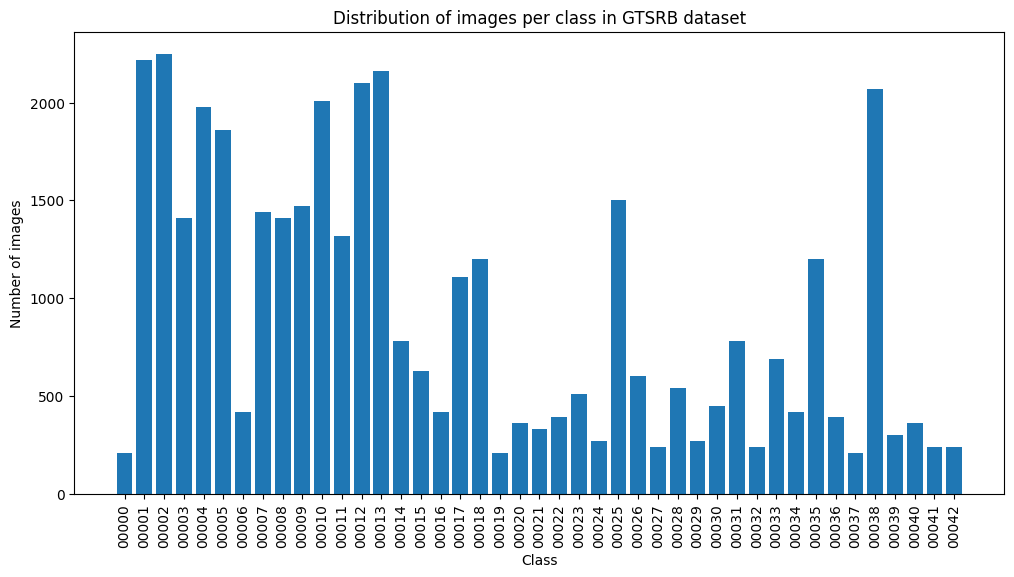

In [122]:
# Count the number of images per class
class_counts = Counter([label for _, label in tqdm(dataset)])

# Get class names from the dataset
class_names = [dataset.classes[idx] for idx in class_counts.keys()]

# Plot the distribution of images per class
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of images per class in GTSRB dataset')
plt.xticks(rotation=90)
plt.show()

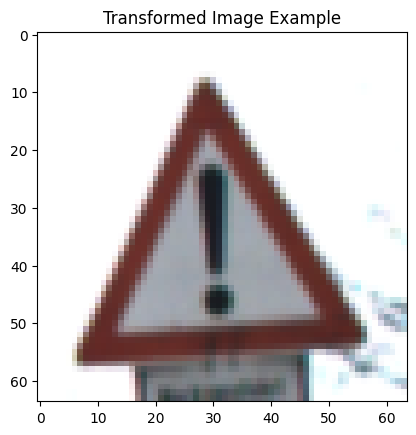

In [123]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
example_image, _ = train_dataset[0]
show_image(example_image)

### Training & Evaluation

In [124]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function and optimizer
model = TrafficSignCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [125]:
# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.98it/s]


Epoch [1/5], Loss: 0.9325


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.88it/s]


Epoch [2/5], Loss: 0.1303


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.80it/s]


Epoch [3/5], Loss: 0.0634


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.78it/s]


Epoch [4/5], Loss: 0.0428


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.63it/s]

Epoch [5/5], Loss: 0.0403


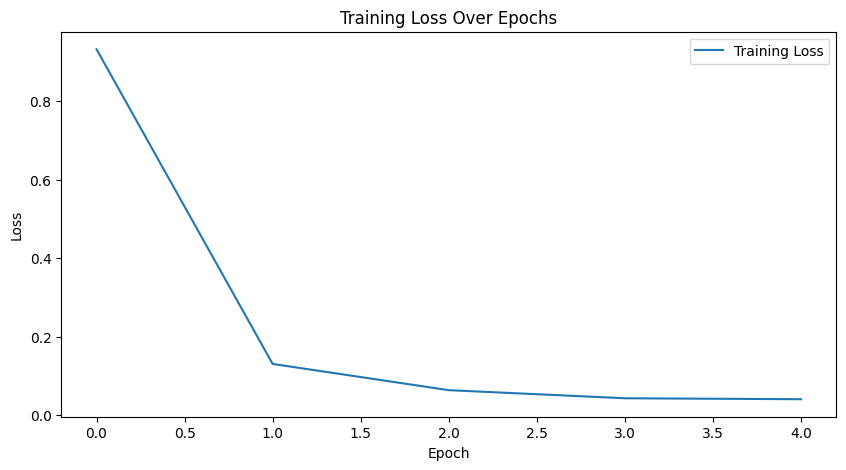

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [127]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 50.52it/s]

Accuracy: 98.14%


### Attack
- patch size
- patch position
- patch transparency (alpha)

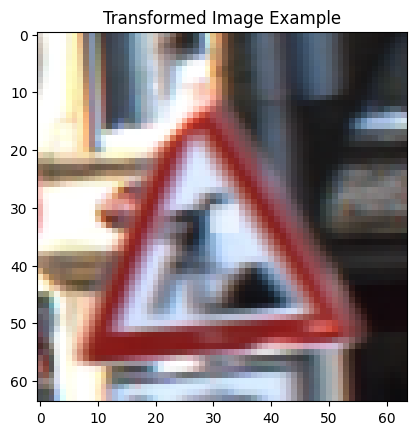

In [138]:
def add_white_rectangle(image, rect_size=(5, 5), position=(30, 30), alpha=0.5):
    image = image.clone()
    for c in range(image.size(0)):  # Iterate over color channels
        image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]] = \
            alpha * 1.0 + (1 - alpha) * image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]]
    return image

example_image, _ = val_dataset[1]
patch_image = add_white_rectangle(example_image)
show_image(patch_image)

In [129]:
# Evaluation after Attack 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([add_white_rectangle(img) for img in images])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {100 * correct / total:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.09it/s]

Accuracy: 82.21%


In [130]:
# Attack: Different Transparecy
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.10it/s]


Alpha: 0.0, Accuracy: 98.14%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.07it/s]


Alpha: 0.2, Accuracy: 92.63%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.10it/s]


Alpha: 0.4, Accuracy: 85.23%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.10it/s]


Alpha: 0.6, Accuracy: 79.48%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.10it/s]


Alpha: 0.8, Accuracy: 74.65%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 36.15it/s]

Alpha: 1.0, Accuracy: 70.49%


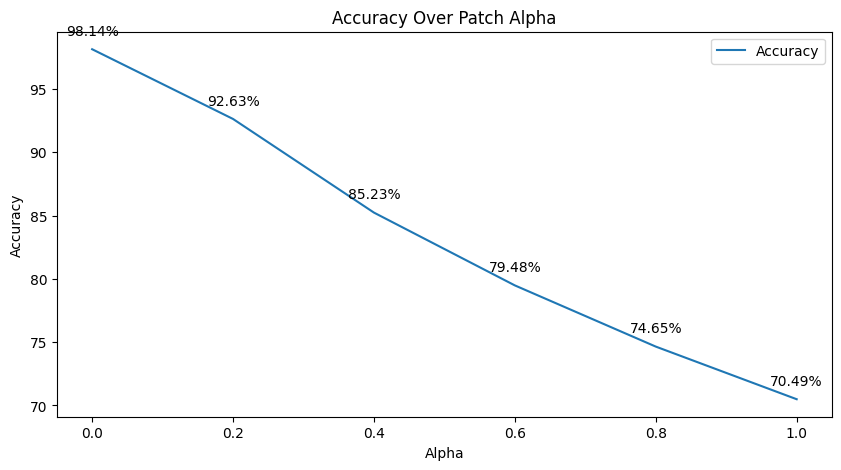

In [131]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2f}%', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()